# А/В-тест и проверка гипотез по увеличению выручки интернет-магазина

## Структура проекта:
* Часть 1. [Приоритизация гипотез](#hypothesis)
* Часть 2. [Анализ A/B-теста](#ab_testing)
    * 2.1. [Предобработка данных](#preprocessing)
    * 2.2. [Анализ А/В-теста](#ab_test)
    * 2.3. [Расчет статистической значимости](#p_value)
    * 3. [Общий вывод](#conclusion)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#вывести полное название гипотез
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

## Часть 1. Приоритизация гипотез.
<a id="hypothesis"></a>

###  Описание данных
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [29]:
hypothesis = pd.read_csv('data/hypothesis.csv')

In [30]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [31]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [32]:
hypothesis.describe()

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [33]:
hypothesis.columns = hypothesis.columns.str.lower()

Видим 9 гипотез по увеличению выручки интернет-магазина, формат данных правильный, баллы распределены от 1 до 10 (в Confidence - до 9, видимо на 100% ни в одной гипотезе не уверены)

**фреймворк ICE**

In [34]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 1)
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Наиболее перспективные гипотезы по ICE:


- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.

Посмотрим, изменится ли ситуация после использования фреймворка RICE

**фреймворк RICE**

In [35]:
# функция для выделения цветом максимального значения в столбце
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [36]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_prioritization = hypothesis[['hypothesis', 'RICE', 'ICE']].sort_values(by=['RICE', 'ICE'], ascending=False)
hypothesis_prioritization.style.apply(highlight_max, subset=pd.IndexSlice[:, ['RICE', 'ICE']])

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000,11.200000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000,7.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000,13.300000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000,8.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000,1.100000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000,1.300000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000,1.000000


Здесь ситуация изменилась, самые перспективные гипотезы: 
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- Запустить акцию, дающую скидку на товар в день рождения.



Гипотеза *о акции, дающую скидку на товар в день рождения*, недорогая, сильно затронет пользователей, мы в ней уверены, но охват пользователй оказался небольшим. Поэтому она стала не самой интересной для увеличения выручки. Зато гипотеза *о добавлении блоков рекомендаций товаров* имеет широкий охват, поэтому оказалась более перспективной, чем казалась на перый взгляд.

## Часть 2. Анализ A/B-теста
<a id="ab_testing"></a>

###  Описание данных
**Таблица orders:**
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.


**Таблица visitors:**
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## 2.1. Предобработка данных
<a id="preprocessing"></a>

In [37]:
orders = pd.read_csv('data/orders.csv')
visitors = pd.read_csv('data/visitors.csv')

In [38]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [39]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [40]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [41]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [42]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [43]:
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [44]:
visitors['date'].describe()

count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Заменили формат дат на корректные, данные в обеих таблицах представлены за аналогичные промежутки времени - с 1 августа 2019г. по 31 августа 2019г. 

Проверим, сколько пользователей в группах А и В

In [45]:
orders.groupby('group').nunique()

,transactionId,visitorId,date,revenue,group
group,,,,,
A,557,503,31,419,1
B,640,586,31,450,1


Видим, что численность групп различается 503 пользователя в группе А и 586 - в Б. Численность группы Б на 16 % выше. В нашем случае метриками будут являться относительные значения, доли, поэтому такая большая разница не проблематична. Но стоит проверить, есть ли пользователи, которые попали в обе группы сразу.

In [46]:
orders.groupby('visitorId')['group'].unique()

visitorId
5114589          [B]
6958315          [B]
8300375       [B, A]
11685486         [A]
39475350         [B]
               ...  
4266935830    [A, B]
4278982564       [A]
4279090005       [B]
4281247801       [B]
4283872382       [B]
Name: group, Length: 1031, dtype: object

Такие пользователи есть, посчитаем сколько их

In [47]:
users_in_group = orders.groupby('visitorId')['group'].nunique()
(users_in_group > 1).sum()

58

In [48]:
(users_in_group > 1).sum()/users_in_group.shape[0]

0.05625606207565471

Это немного, но некорректно считать метрики с учетом того, что есть такие пользователи. Так как их всего 5% можно их удалить

In [49]:
users_in_both_group = users_in_group[users_in_group > 1].index
users_in_both_group

Int64Index([   8300375,  199603092,  232979603,  237748145,  276558944,
             351125977,  393266494,  457167155,  471551937,  477780734,
             818047933,  963407295, 1230306981, 1294878855, 1316129916,
            1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
            1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
            2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
            2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
            2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
            3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
            3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
            3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
            4186807279, 4256040402, 4266935830],
           dtype='int64', name='visitorId')

In [50]:
orders = orders[np.logical_not(orders['visitorId'].isin(users_in_both_group))]

# проверим количество уникальных пользователей после удаления, все сходится
orders[np.logical_not(orders['visitorId'].isin(users_in_both_group))]['visitorId'].nunique()

973

**ВЫВОД**

Пропусков в данных не обнаружено. Формат дат изменен на корректный, границы дат сходятся в обоих таблицах. Численность групп различается: 503 пользователя в группе А и 586 - в Б. Численность группы Б на 16 % выше. В нашем случае метриками будут являться относительные значения, доли, поэтому такая большая разница не проблематична. Но при проверке нашлись пользователи, которые относятся сразу к обеим группам (5% пользователей). Эти пользователи удалены из датасета, так как с ними проверять результаты А/В теста некорректно.

## 2.2. Анализ А/В-теста
<a id="ab_test"></a>

**График кумулятивной выручки по группам**

In [51]:
# создадим массив с уникальной парой значений дата - группа
data_group = orders[['date', 'group']].drop_duplicates()

# создадим аггрегированные таблицы с накопленной по дням информацией о заказах, пользователях, выручки
orders_aggregated = data_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]
                                                      .agg({'date': 'max', 
                                                            'group': 'max', 
                                                            'transactionId': pd.Series.nunique,
                                                            'visitorId': pd.Series.nunique,
                                                            'revenue': 'sum'}), axis=1)\
                               .sort_values(by=['date', 'group'])
                                                      
visitors_aggregated = data_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                         visitors['group'] == x['group'])]
                                                          .agg({'date': 'max', 
                                                                'group': 'max', 
                                                                'visitors': 'sum'}), axis=1)\
                                .sort_values(by=['date', 'group'])

# объединим обе таблицы в одну
data_cumulative = pd.merge(orders_aggregated, visitors_aggregated, on=['date', 'group'])
data_cumulative.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
data_cumulative

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


In [52]:
# сделаем отдельные таблицы для каждой группы с нужными нам для графиков столбцами
data_cumulative_A = data_cumulative[data_cumulative['group'] == 'A'][['date','revenue', 'orders', 'visitors']]
data_cumulative_B = data_cumulative[data_cumulative['group'] == 'B'][['date','revenue', 'orders', 'visitors']]
data_cumulative_A.head()

,date,revenue,orders,visitors
0,2019-08-01,142779,23,719
2,2019-08-02,234381,42,1338
4,2019-08-03,346854,66,1845
6,2019-08-04,388030,77,2562
8,2019-08-05,474413,99,3318


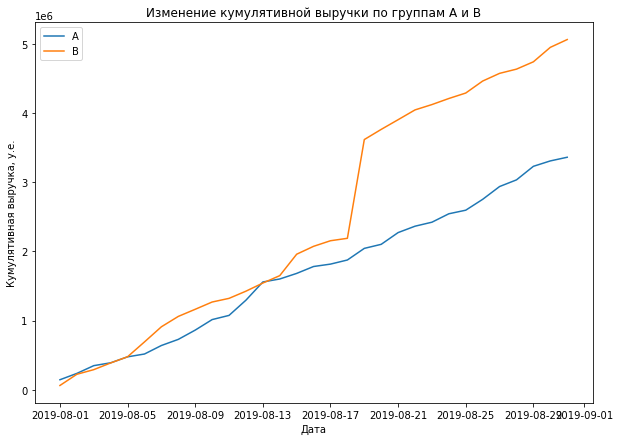

In [58]:
# построим график кумулятивной выручки по дням в каждой группе
plt.figure(figsize=(10,7))
plt.title('Изменение кумулятивной выручки по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, у.е.')
plt.plot(data_cumulative_A['date'], 
         data_cumulative_A['revenue'], 
         label='A')
plt.plot(data_cumulative_B['date'], 
         data_cumulative_B['revenue'], 
         label='B')
plt.legend();

Выручка обеих групп растет на протяжении всего теста. Первые 5 дней теста выручка обеих групп соприкасается, далее - у группы В видим преимущество, есть резкий скачок роста в середине исследуемого месяца, это может быть признаком выбросов (очень дорогих заказов), либо резким увеличением числа заказов. Данные анамалии увидим в проекте ниже.

**График кумулятивного среднего чека по группам**

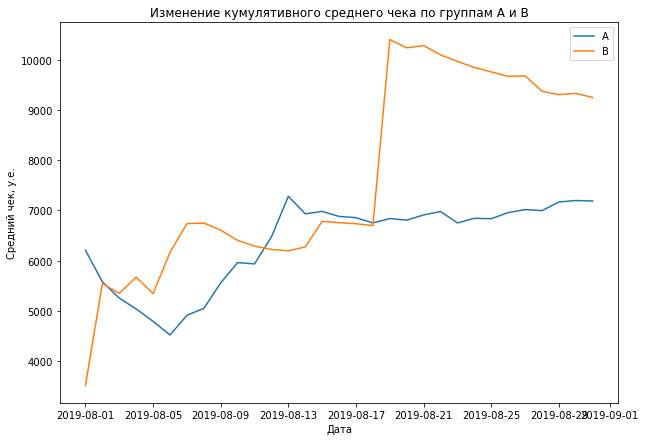

In [59]:
# чтобы узнать кумулятивный средний чек, разделим выручку на число заказов
plt.figure(figsize=(10,7))
plt.title('Изменение кумулятивного среднего чека по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Средний чек, у.е.')
plt.plot(data_cumulative_A['date'], 
         data_cumulative_A['revenue'] / 
         data_cumulative_A['orders'], 
         label='A')
plt.plot(data_cumulative_B['date'], 
         data_cumulative_B['revenue'] / 
         data_cumulative_B['orders'], 
         label='B')
plt.legend();

Снова видим сильный всплеск у группы В в середине месяца, похоже, что средний чек в последние пару дней стабилизировался, но было бы неплохо немного увеличить длительность тестирования, чтобы в этом убедиться. Средний чек группы В визуально кажется значительно больше.

**График относительного изменения кумулятивного среднего чека группы B к группе A**

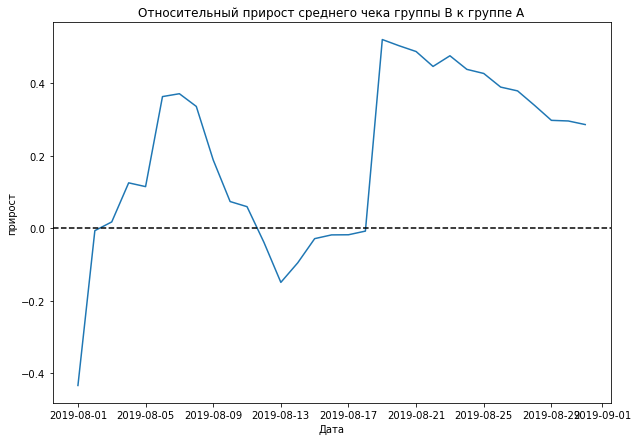

In [60]:
# соединим таблицы с группами в одну 
data_cumulative_merged = data_cumulative_A.merge(data_cumulative_B, on='date', suffixes=['A', 'B'])

plt.figure(figsize=(10,7))
plt.title('Относительный прирост среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('прирост')
plt.plot(data_cumulative_merged['date'], 
         (data_cumulative_merged['revenueB'] / 
         data_cumulative_merged['ordersB']) / 
         (data_cumulative_merged['revenueA'] / 
         data_cumulative_merged['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--');

Все тот же всплеск, в начале скачет график, в конце после всплеска снижается и возможно выходит на стабильный уровень. Но данных опять же не хватает для уверенности. 

**График кумулятивной конверсии по группам**

(737272.0, 737302.0, 0.0, 0.06)

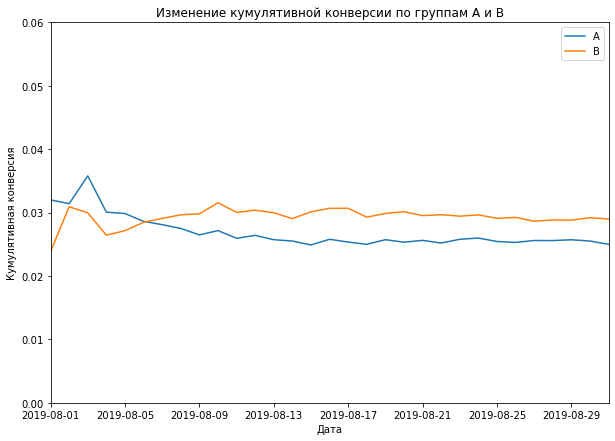

In [61]:
# посчитаем конверсию

data_cumulative['conversion'] = data_cumulative['orders'] / data_cumulative['visitors']
data_cumulative_conversion_A = data_cumulative[data_cumulative['group'] == 'A']
data_cumulative_conversion_B = data_cumulative[data_cumulative['group'] == 'B']


# построим графики

plt.figure(figsize=(10,7))
plt.title('Изменение кумулятивной конверсии по группам А и В')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.plot(data_cumulative_conversion_A['date'], data_cumulative_conversion_A['conversion'], label='A')
plt.plot(data_cumulative_conversion_B['date'], data_cumulative_conversion_B['conversion'], label='B')
plt.legend();
# зададим масштаб осей, чтобы из-за сильного приближения не было видно сильных скачков
plt.axis([data_cumulative_conversion_A['date'].min(), 
          data_cumulative_conversion_A['date'].max(), 
          0, 
          0.06])

Видим, что сначала конверсия группы В была ниже, но через дней 5 после начала теста поползла вверх и выровнялась там, конверсия группы А снизилась и также заняла стабильное положение

**График относительного изменения кумулятивной конверсии группы B к группе A**

In [62]:
data_cumulative_conversion_A.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837


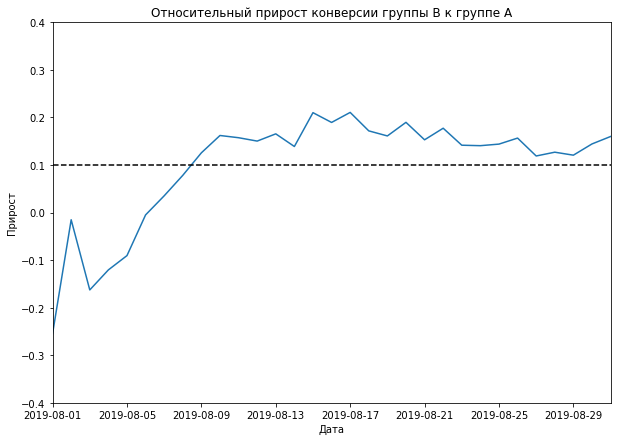

In [63]:
data_cumulative_conversion_merge = data_cumulative_conversion_A[['date', 'conversion']]\
        .merge(data_cumulative_conversion_B[['date', 'conversion']], on='date', suffixes=['A', 'B'])


plt.figure(figsize=(10,7))
plt.title('Относительный прирост конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Прирост')
plt.plot(data_cumulative_conversion_merge['date'], 
         data_cumulative_conversion_merge['conversionB'] / 
         data_cumulative_conversion_merge['conversionA']-1)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axis([data_cumulative_conversion_A['date'].min(), 
          data_cumulative_conversion_A['date'].max(), 
          -0.4, 
          0.4]);

Видим, что в начале теста есть скачки, затем группа В растет, затем немного снижается прирост в конверсии и, возможно, что стабилизируется. Но опять же было бы неплохо увидеть продолжение графика

**Точечный график количества заказов по пользователям**

In [64]:
orders_by_visitor = orders.groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_visitor.sort_values(by='transactionId', ascending=False)

,visitorId,transactionId
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


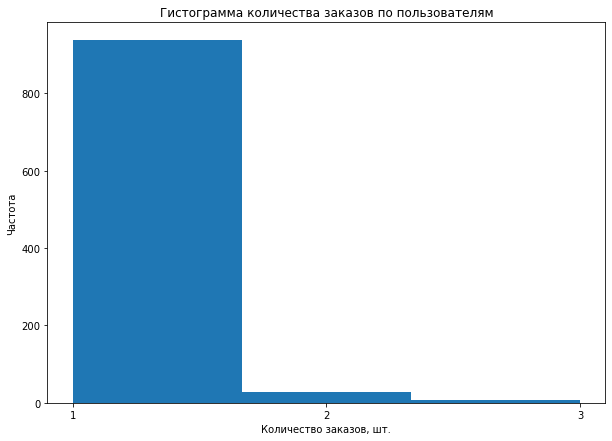

In [65]:
plt.figure(figsize=(10,7))
plt.title('Гистограмма количества заказов по пользователям')
plt.xlabel('Количество заказов, шт.')
plt.ylabel('Частота')
plt.xticks(np.arange(1, 4, 1))
plt.hist(orders_by_visitor['transactionId'], bins=3);

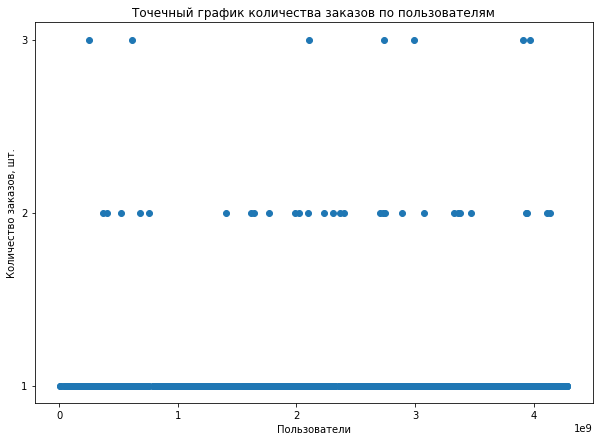

In [66]:
plt.figure(figsize=(10,7))
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов, шт.')
plt.yticks(np.arange(1, 4, 1))
plt.scatter(orders_by_visitor['visitorId'], orders_by_visitor['transactionId']);

Большинство пользователей совершают 1 заказ, 2 заказа уже реже, 3 - совсем редко

**95-й и 99-й перцентили количества заказов на пользователя**

In [67]:
np.percentile(orders_by_visitor['transactionId'], [95, 99])

array([1., 2.])

Границей для аномальных пользователей будем считать более 2-ух заказов, их совершает всего 1% пользователей

**Точечный график стоимостей заказов**

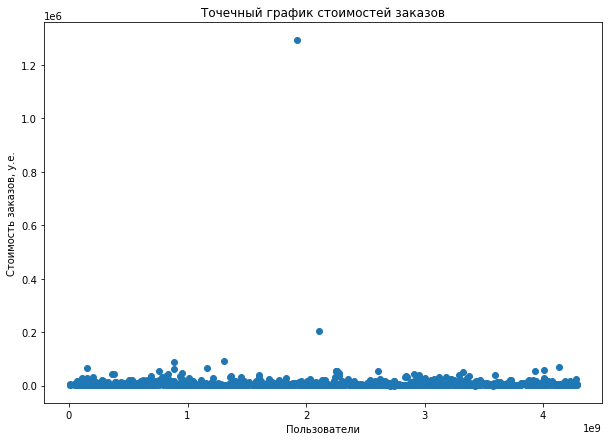

In [68]:
plt.figure(figsize=(10,7))
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов, у.е.')
plt.scatter(orders['visitorId'], orders['revenue']);

Видим, что выбивающихся заказов немного, но один из них очень сильно выбивается из общей картины и портит средние значения и видимо, делает замеченные на графиках всплески. С учетом медианного значения в 3 тыс, этот заказ на сумму 1,3 млн

In [69]:
orders['revenue'].median(), orders['revenue'].mean()

(2955.0, 8300.814960629921)

In [70]:
orders['revenue'].sort_values(ascending=False).head(10)

425     1294500
1196     202740
1136      92550
744       86620
743       67990
1103      66350
1099      65710
949       60450
940       58550
131       53904
Name: revenue, dtype: int64

**95-й и 99-й перцентили стоимости заказов**

In [71]:
np.percentile(orders['revenue'], [95, 97, 98, 99])

array([26785., 34792., 42353., 53904.])

Выберем границу для аномальных заказов в 40000, их совершает всего 2-3% пользователей

## 2.3. Расчет статистической значимости
<a id="p_value"></a>

**Статистическая значимость различий в конверсии между группами по «сырым» данным**

У нас есть датафрейм data_cumulative_merged, содержащий информацию о кумулятивных метриках по датам и группам (выручка, число заказов, число посетителей сайта). Для расчетов нам также понадобятся не кумулятивные столбцы с выручкой, заказами и посетителями сайта. Посчитаем и добавим к имеющимся данным.

In [72]:
data_cumulative_merged.head()

,date,revenueA,ordersA,visitorsA,revenueB,ordersB,visitorsB
0,2019-08-01,142779,23,719,59758,17,713
1,2019-08-02,234381,42,1338,221801,40,1294
2,2019-08-03,346854,66,1845,288850,54,1803
3,2019-08-04,388030,77,2562,385740,68,2573
4,2019-08-05,474413,99,3318,475648,89,3280


In [73]:
data_cumulative_merged.columns = ['date', 'revenue_cumA', 'orders_cumA', 'visitors_cumA', 
                                  'revenue_cumB', 'orders_cumB', 'visitors_cumB']

In [74]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [75]:
# посчитаем заказы и выручку за каждый день по каждой группе
orders_per_dayA = orders[orders['group']=='A'].groupby('date', as_index=False)\
                                              .agg({'transactionId': pd.Series.nunique, 
                                                    'revenue': 'sum'})
orders_per_dayA.columns = ['date', 'orders_per_dayA', 'revenue_per_dayA']

orders_per_dayB = orders[orders['group']=='B'].groupby('date', as_index=False)\
                                              .agg({'transactionId': pd.Series.nunique, 
                                                    'revenue': 'sum'})
orders_per_dayB.columns = ['date', 'orders_per_dayB', 'revenue_per_dayB']

# посчитаем количество посетителей за каждый день по каждой группе
visitors_per_dayA = visitors[visitors['group']=='A'].groupby('date', as_index=False)\
                                              .agg({'visitors': 'sum'})
visitors_per_dayA.columns = ['date', 'visitors_per_dayA']

visitors_per_dayB = visitors[visitors['group']=='B'].groupby('date', as_index=False)\
                                              .agg({'visitors': 'sum'})
visitors_per_dayB.columns = ['date', 'visitors_per_dayB']

In [76]:
# соединим все столбцы в один датафрейм
data_for_test = data_cumulative_merged.merge(orders_per_dayA, on='date')\
                                      .merge(orders_per_dayB, on='date')\
                                      .merge(visitors_per_dayA, on='date')\
                                      .merge(visitors_per_dayB, on='date')
                                         
data_for_test.head()

,date,revenue_cumA,orders_cumA,visitors_cumA,revenue_cumB,orders_cumB,visitors_cumB,orders_per_dayA,revenue_per_dayA,orders_per_dayB,revenue_per_dayB,visitors_per_dayA,visitors_per_dayB
0,2019-08-01,142779,23,719,59758,17,713,23,142779,17,59758,719,713
1,2019-08-02,234381,42,1338,221801,40,1294,19,91602,23,162043,619,581
2,2019-08-03,346854,66,1845,288850,54,1803,24,112473,14,67049,507,509
3,2019-08-04,388030,77,2562,385740,68,2573,11,41176,14,96890,717,770
4,2019-08-05,474413,99,3318,475648,89,3280,22,86383,21,89908,756,707


In [77]:
data_cumulative_merged.shape, data_for_test.shape

((31, 7), (31, 13))

In [78]:
# проверим, сходится ли с посчитанными ранее данными
print(orders_per_dayA['revenue_per_dayA'].cumsum().sum() - data_for_test['revenue_cumA'].sum())
print(orders_per_dayB['revenue_per_dayB'].cumsum().sum() - data_for_test['revenue_cumB'].sum())
print(orders_per_dayA['orders_per_dayA'].cumsum().sum() - data_for_test['orders_cumA'].sum())
print(orders_per_dayB['orders_per_dayB'].cumsum().sum() - data_for_test['orders_cumB'].sum())
print(visitors_per_dayA['visitors_per_dayA'].cumsum().sum() - data_for_test['visitors_cumA'].sum())
print(visitors_per_dayB['visitors_per_dayB'].cumsum().sum() - data_for_test['visitors_cumB'].sum())

0
0
0
0
0
0


In [79]:
# создадим переменные, в которых укажем число заказов для пользователей

orders_per_userA = orders[orders['group']=='A'].groupby('visitorId', as_index=False)\
                                               .agg({'transactionId': pd.Series.nunique})
orders_per_userA.columns = ['userId', 'orders']

orders_per_userB = orders[orders['group']=='B'].groupby('visitorId', as_index=False)\
                                               .agg({'transactionId': pd.Series.nunique})
orders_per_userB.columns = ['userId', 'orders']

# создадим переменные, где у пользователей без заказов проставим 0
sampleA = pd.concat([orders_per_userA['orders'], 
                     pd.Series(0, 
                               index=np.arange(data_for_test['visitors_per_dayA'].sum() 
                                               - len(orders_per_userA['orders'])), 
                               name='orders')], 
                    axis=0)

sampleB = pd.concat([orders_per_userB['orders'], 
                     pd.Series(0, 
                               index=np.arange(data_for_test['visitors_per_dayB'].sum() 
                                               - len(orders_per_userB['orders'])), 
                               name='orders')], 
                    axis=0)

Нулевая гипотеза - группа А и группа В в конверсии не различаются. 
Альтернативная гипотеза - в конверсии групп А и В имеются различия.

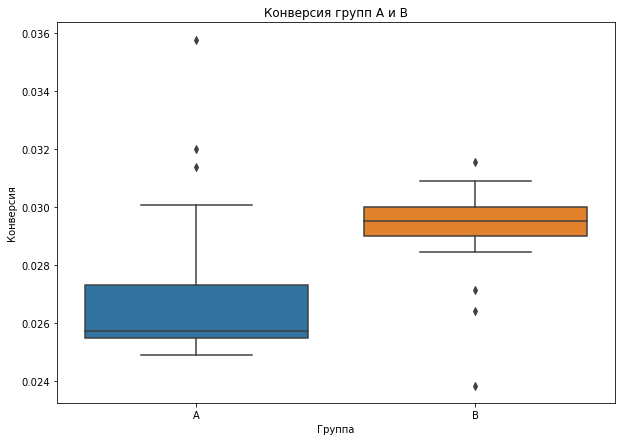

In [81]:
plt.figure(figsize=(10,7))
plt.title('Конверсия групп А и В')
sns.boxplot(x='group', y='conversion', data=data_cumulative).set(xlabel='Группа',
                                                                 ylabel='Конверсия');

Визуально кажется, что конверсии различаются, проверим по тесту Уилкоксона-Манна-Уитни

In [82]:
# посчитаем стат значимость различий в конверсии между группами
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')
print('p-значение:', results[1])
if (results[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


print('Относительный прирост конверсии группы B к группе A', sampleB.mean() / sampleA.mean()-1)

p-значение: 0.011018084110014691
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы B к группе A 0.1597977924896936


**Вывод** Значение p-value близко к 0. То есть конверсия между группами различается в генеральной совокупности. И данные различия не случайны.

**Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным**

Нулевая гипотеза - средний чек в группах А и Б не различаются. 
Альтернативная гипотеза - в среднем чеке групп А и Б имеются различия.

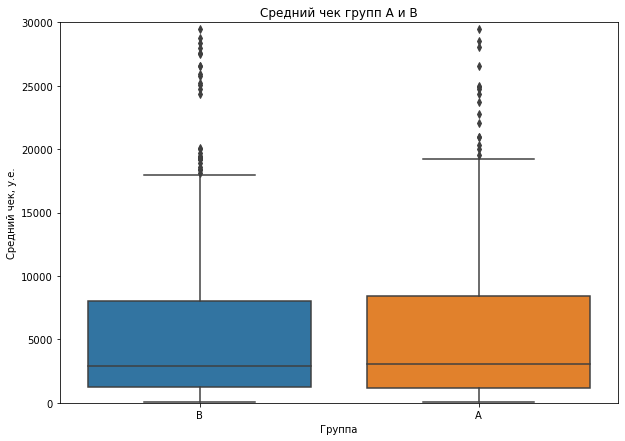

In [83]:
plt.figure(figsize=(10,7))
plt.title('Средний чек групп А и В')
plt.ylim(0, 30000)
sns.boxplot(x='group', y='revenue', data=orders).set(xlabel='Группа',
                                                     ylabel='Средний чек, у.е.');

Визуально различий в среднем чеке нет

In [84]:
results = stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], 
                             orders[orders['group'] == 'B']['revenue'], 
                             alternative = 'two-sided')
print('p-значение:', results[1])
if (results[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


print('Относительный прирост среднего чека группы B к группе A', \
      orders[orders['group'] == 'B']['revenue'].mean() / 
      orders[orders['group'] == 'A']['revenue'].mean() - 1)

p-значение: 0.8294908998149533
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B к группе A 0.28660287636871096


Полученное значение p-value говорит о том, что хотя Группы А и Б различаются по средним чекам, при соблюдении условий нулевой гипотезы вероятность получить такие и большие различия составляет в около 83%. У нас недостаточно оснований отклонить нулевую гипотезу. Наши данные согласуются с нулевой гипотезой.

**Статистическая значимость различий в конверсии между группами по «очищенным» данным**

Примем пользователей, совершивших больше 2-ёх заказов или купивших на сумму более 40000, за аномальных

In [85]:
# создадим таблицы с пользователями, совершившими более 3 заказов 
# и с пользователями, совершившими заказы на сумму более 40000

users_with_many_orders = pd.concat([orders_per_userA[orders_per_userA['orders'] > 2],
                                    orders_per_userA[orders_per_userB['orders'] > 2]], 
                                   axis=0)['userId']
users_with_expensive_orders = orders[orders['revenue'] > 40000]['visitorId']


# объединим этих пользователей и удалим дубликаты

abnormal_users = pd.concat([users_with_many_orders, 
                            users_with_expensive_orders], 
                           axis=0)\
                    .drop_duplicates()\
                    .sort_values()
abnormal_users.shape

(30,)

30 пользователей аномальные, их мало и можно удалить и посчитать стат значимость без них

In [86]:
sampleAFiltered = pd.concat([orders_per_userA
                        [np.logical_not(orders_per_userA['userId'].isin(abnormal_users))]['orders'],
                        pd.Series(0, 
                                  index=np.arange(data_for_test['visitors_per_dayA'].sum()
                                                  - len(orders_per_userA['orders'])),
                                  name='orders')],
                            axis=0)
sampleBFiltered = pd.concat([orders_per_userB
                        [np.logical_not(orders_per_userB['userId'].isin(abnormal_users))]['orders'],
                        pd.Series(0, 
                                  index=np.arange(data_for_test['visitors_per_dayB'].sum()
                                                  - len(orders_per_userB['orders'])),
                                  name='orders')],
                            axis=0)

Нулевая гипотеза - группа А и группа В после удаления аномальных пользователей в конверсии  не различаются. 
Альтернативная гипотеза - в конверсии групп А и В после удаления аномальных пользователей имеются различия.

In [87]:
# посчитаем стат значимость в конверсии по очищенным данным
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')
print('p-значение:', results[1])
if (results[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


print('Относительный прирост конверсии группы B к группе A', sampleBFiltered.mean() / sampleAFiltered.mean()-1)

p-значение: 0.002911844602754345
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы B к группе A 0.2236845680668731


Статистическая значимость стала еще меньше при удалении аномальных пользователей. Относительный прирост конверсии группы B к группе A увеличился до 22.4%. Различия в конверсии не случайны, после удаления аномальных пользователей уверенность в этом повышается

**Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным**

Нулевая гипотеза - после удаления из данных аномальных пользователей средний чек в группах А и Б не различается. 
Альтернативная гипотеза - после удаления из данных аномальных пользователей в среднем чеке групп А и Б имеются различия.

In [88]:
results = stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', 
                                                   np.logical_not(orders['visitorId']
                                                            .isin(abnormal_users)))]['revenue'],
                             orders[np.logical_and(orders['group'] == 'B', 
                                                   np.logical_not(orders['visitorId']
                                                            .isin(abnormal_users)))]['revenue'],
                            alternative = 'two-sided')
print('p-значение:', results[1])
if (results[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


print('Относительный прирост среднего чека группы B к группе A', \
      orders[np.logical_and(orders['group'] == 'B', 
                            np.logical_not(orders['visitorId']
                                 .isin(abnormal_users)))]['revenue'].mean() / 
      orders[np.logical_and(orders['group'] == 'A', 
                            np.logical_not(orders['visitorId']
                                .isin(abnormal_users)))]['revenue'].mean() - 1)

p-значение: 0.8788308087677699
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B к группе A 0.0608396168621963


Разница между сегментами сократилась с 29% до 6%, P-value немного повысился. Выводы прежние: у нас недостаточно оснований отклонить нулевую гипотезу. Наши данные согласуются с нулевой гипотезой, особенно после удаления аномальных значений, которые влияли на относительный прирост.

## 3. Общий вывод
<a id="conclusion"></a>

Итак, в ходе проекта, проделанно следующее:

**В Части 1** по приотизации гипотез выявлены следующие перспективные гипотезы по фреймворку RICE:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- Запустить акцию, дающую скидку на товар в день рождения.

Фреймворк ICE показывал нам другие перспективы, но так как охват был не учтен, самая перспективная гипотеза по ICE (о акции, дающую скидку на товар в день рождения) откатилась на 5 место по RICE. Зато гипотеза *о добавлении блоков рекомендаций товаров* имеет широкий охват, поэтому оказалась более перспективной, чем казалась на первый взгляд по ICE.


**В Части 2** по анализу А/В-тестов:
1. Проведена предобработка данных, в ходе которой форматы дат приведены к правильному типу. Данные проверены на корректность: обнаружены пользователи, относящиеся к обеим группам теста. Их всего 58 человек (5%), в связи с этим было решено удалить их из датасэта и продолжить анализ результатов А/В-теста. Также обнаружено, что численность групп различается: группа Б на 16 % больше группы А. В нашем случае метриками будут являться относительные значения, доли, поэтому такая большая разница не проблематична.

2. Проведен анализ результатов А/В-теста. Можно выделить значимые моменты:

- В ходе анализа кумулятивной выручки и среднего чека по группам, увидели, что группа В прибыльнее. Также заметили всплески на графиках, которые свидетельствуют об аномальных значениях.
- Относительный прирост кумулятивного среднего чека группы B к группе A скачет на протяжении первой половины теста, затем имеет всплеск и начинает выравниваться. Здесь нам предположений строить не удается, так как мешают выбросы и для стабилизации данного прироста, возможно, понадобится больше времени. Прирост по конверсии положительный, также скачет, и вероятно, выравнивается в конце теста.
- При построении точечных графиков количества заказов по пользователям и стоимости заказов и расчета 95 и 99 персентилей, были выявлены пороги для аномальных значений. Пользователей, совершившие более 2-ух заказов и заказывающие на сумму более 40000 будем считать аномальными.
- Обнаружена статистическая значимость в различии конверсии между группами и по "сырым" данным, и по очищенным. После очистки данных от аномальных пользователей, статистическая значимость стала еще меньше, а относительный прирост конверсии группы B к группе A увеличился до 22.4%.
- Статистическая значимость в различии по среднему чеку не обнаружена. После очистки данных разница между группами по среднему чеку сократилась с 29% до 6%, что удостоверило нас в отсутсвии статистически значимых различий.

**В связи с этим, считаю правильным остановить тест, зафиксировать победу группы В. Так как конверсия выросла довольно сильно (на 22.4%)** 